# Summary

1. **Quantum Jump Method**

2. **Two level atom:**
- Choose initial state $\ket{\psi(0)}=\ket{g}\otimes\ket{g}$
    - [Figure 0](#Figure0) : excitation density for two trajectories
    - [Figure 1](#Figure1) : $n_{e}(t)$ - numerical result
    - [Figure 2](#Figure2) : $n_{e}(t)$ - exact result
    - [Figure 3](#Figure3) : $n_{e}(t)$ - numerics vs. exact
      

4. **Interacting atoms:**
- Choose initial state $\ket{\psi(0)}=\ket{g}\otimes\ket{g}$   
    - [Figure 4-1](#Figure4-1) : $n_{e,1}(t)$, $n_{e,2}(t)$ - numerical result 
    - [Figure 4-2](#Figure4-2) : $n_{e,1}(t)$, $n_{e,2}(t)$ - exact result 
    - [Figure 4-3](#Figure4-3) : $n_{e,1}(t)$, $n_{e,2}(t)$ - numerics vs. exact

$\newline$  
- Choose initial state $\ket{\psi(0)}=\ket{g}\otimes\ket{e}$
    - [Figure 4-4](#Figure4-4) : $n_{e,1}(t)$, $n_{e,2}(t)$ - numerical result
    - [Figure 4-5](#Figure4-5) : $n_{e,1}(t)$, $n_{e,2}(t)$ - exact result  
    - [Figure 4-6](#Figure4-6) : $n_{e,1}(t)$ - numerics vs. exact 
    - [Figure 4-7](#Figure4-7) : $n_{e,2}(t)$ - numerics vs. exact  

In [303]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.linalg import expm
from scipy.integrate import odeint
from scipy.integrate import ode
from scipy.optimize import fsolve
from sympy import Matrix
from tqdm import tqdm
import time

In [2]:
# For N = 1 , {|g), |e)}
# For N = 2 , {|g)|g), |g)|e), |e)|g), |e)|e)}
def phi_basis_vecs(N):
    phi = np.array([[0+0j]*(2**N)]).transpose()
    base = []
    for i in range(2**N):
        phi[i] += 1
        base.append(phi)
        phi = np.array([[0+0j]*(2**N)]).transpose()
    return base

# For N = 1 , {GG=|g)(g|, GE=|g)(e|, EG=|e)(g|, EE=|e)(e|}
# For N = 2 , {GGGG,GGGE,GGEG,GGEE,GEGG,GEGE,GEEG,GEEE,EGGG,EGGE,EGEG,EGEE,EEGG,EEGE,EEEG,EEEE}
def rho_basis_ops(N):
    zero = np.zeros((2,2), dtype = complex)
    rho = np.zeros((2,2), dtype = complex)
    base = []
    for i in range(N-1):
        rho = np.kron(rho, zero)
    for i in range(2**N):
        for j in range(2**N):
            rho[i][j] = 1
            base.append(rho)
            rho= np.zeros((rho.shape), dtype = complex)
    return base

In [3]:
def id(N):
    matrix = np.array([[1, 0],[0, 1]], dtype = complex)
    identity = np.array([[1, 0],[0, 1]], dtype = complex)
    for i in range(N-1):
        matrix = np.kron(matrix,identity)
    return matrix

def S_x(N, n):
    s_x = np.array([[0, 1], [1, 0]], dtype=complex)
    identity = np.array([[1, 0],[0, 1]], dtype = complex)
    matrix = np.array([1], dtype = complex)
    for i in range(N):
        if i != n-1:
            matrix = np.kron(matrix, identity)
        elif i == n-1:
            matrix = np.kron(matrix, s_x)
    return matrix

def S_plus(N, n):
    s_plus =  np.array([[0, 0], [1, 0]], dtype=complex)
    identity = np.array([[1, 0],[0, 1]], dtype = complex)
    matrix = np.array([1], dtype = complex)
    for i in range(N):
        if i != n-1:
            matrix = np.kron(matrix, identity)
        elif i == n-1:
            matrix = np.kron(matrix, s_plus)
    return matrix

def S_minus(N, n):
    s_minus = np.array([[0, 1], [0, 0]], dtype=complex)
    identity = np.array([[1, 0],[0, 1]], dtype = complex)
    matrix = np.array([1], dtype = complex)
    for i in range(N):
        if i != n-1:
            matrix = np.kron(matrix, identity)
        elif i == n-1:
            matrix = np.kron(matrix, s_minus)
    return matrix

# 1. Quantum Jump method to solve master equation
# Lindblad master equation

$\partial_{t}\rho = -i[H,\rho] +  \gamma(L\rho L^{\dagger}-\frac{1}{2}\{L^{\dagger}L,\rho \})= -i(H_{eff}\rho - \rho H^{\dagger}_{eff})+\gamma L\rho L^{\dagger}$

$H_{eff}= H - \frac{i}{2}\gamma L^{\dagger}L$

# Integrate the wavefunction
Stochastically choose

$\ket{\psi(t+\delta t)} \propto e^{-iH_{eff}\delta t}\ket{\psi(t)} = (I - i H_{eff}\delta t - \frac{1}{2}H_{eff}(\delta t)^{2}+ ...)\ket{\psi(t)}$

$\ket{\psi(t+\delta t)} \propto L\psi(t)$


# In our cases 

Two-level atom

$H = \Omega\sigma^x$

$L = \sigma^-$

$L^\dagger = \sigma^+$

Interacting atoms 

$H = \Omega(\sigma^x_1+\sigma^x_2)$

$L = \frac{1}{\sqrt{2}}\sigma^{-}_{1}+\frac{1}{\sqrt{2}}\sigma^{-}_{2}$

$L^{\dagger} = \frac{1}{\sqrt{2}}\sigma^{+}_{1}+\frac{1}{\sqrt{2}}\sigma^{+}_{2}$



In [148]:
class QuantumSystem:
    def _(init_self, H, gamma, L):
        self.H = H
        self.gamma = gamma
        self.L = L
    def effective_H(self):
        return self.H - 1j/2 * self.gamma * self.L.conj().T @ self.L

In [161]:
def dagger(matrix):
    return np.transpose(np.conj(matrix))

def commutator(matrix_1, matrix_2, sign):
    if sign == 0:
        return matrix_1 @ matrix_2 - matrix_2 @ matrix_1
    else:
        return matrix_1 @ matrix_2 + matrix_2 @ matrix_1

def effective_Hamiltonian(H, gamma, L):
    return H - 1j/2 * gamma * dagger(L) @ L

def jump_probability(state):
    dp = 1- np.linalg.norm(state)
    return dp

# 1. Two level atom

In [273]:
# Define the system
omega = 15
gamma = omega / 3
H = omega * S_x(1,1)
L = S_minus(1,1)
H_eff = effective_Hamiltonian(H,gamma, L)

# Define the simulation parameters
total_time = 1.6
dt = 0.000016
U_eff = expm(-1j * H_eff * dt)
t_length = int(total_time/dt)


In [274]:
N = 2700
N_ne_values = []
N_state_vectors = []
for n in tqdm(range(N)):
    
    # start a new trajectory simulation        
    time_values = []
    state_vectors = []
    ne_values = []

    current_state = phi_basis_vecs(1)[0]
    current_time = 0
    while current_time < total_time:
              
        # propagation
        current_state_1 = U_eff @ current_state                      # get the candidate propagated state

        dp = jump_probability(current_state_1)
        r = np.random.rand()
        if r < dp:                                                   # jump occurs
            time_values.append(current_time)
            current_state = np.sqrt(gamma) * (L @ current_state)     # progapage by acting jump
            current_state = current_state / np.sqrt(dp/dt)           # normalize the state
            state_vectors.append(current_state)
            ne = np.abs(current_state[1][0])**2
            ne_values.append(ne)   
            current_time += 0.005*dt                                  # update time with smaller dt
                       
        else:
            time_values.append(current_time)
            current_state = current_state_1/ np.sqrt(1-dp)           # choose the candidate propagated state
            state_vectors.append(current_state)
            ne = np.abs(current_state[1][0])**2
            ne_values.append(ne)
            current_time += dt                                       # update time with regular dt
 
            
    N_state_vectors.append(np.array(state_vectors))
    N_ne_values.append(np.array(ne_values))

print("Simulation complete")

100%|█████████████████████████████████████| 2700/2700 [2:35:27<00:00,  3.45s/it]

Simulation complete


<a id="Figure0"></a>

<a id="Figure0"></a>

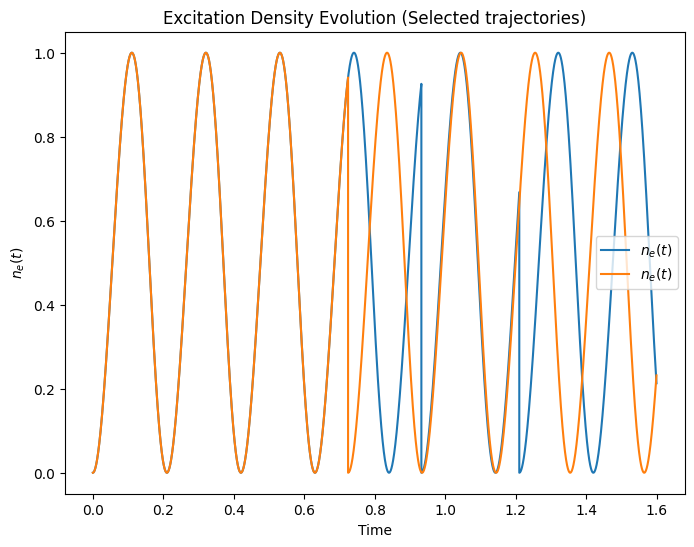

In [275]:
time_values = time_values[:t_length]
for n in range(N):
    N_ne_values[n]=N_ne_values[n][:t_length]


plt.figure(figsize=(8,6))
plt.plot(time_values, N_ne_values[0][:t_length], label=r'$n_{e}(t)$')
plt.plot(time_values, N_ne_values[1][:t_length], label=r'$n_{e}(t)$')
plt.title('Excitation Density Evolution (Selected trajectories)')
plt.xlabel('Time')
plt.ylabel(r'$n_{e}(t)$')
plt.legend()
plt.show()

Obtain $<n_{e}(t)>$ by averaging $n_{e}(t)$ over all trajectories.

In [276]:
ne_avg1 = []
N_ne_sum = np.array([0+0j]*len(N_ne_values[0]), dtype=complex)
for n in range(N):
    N_ne_sum += N_ne_values[n]

avg = N_ne_sum / N
ne_avg1.append(avg)

<a id="Figure1"></a>

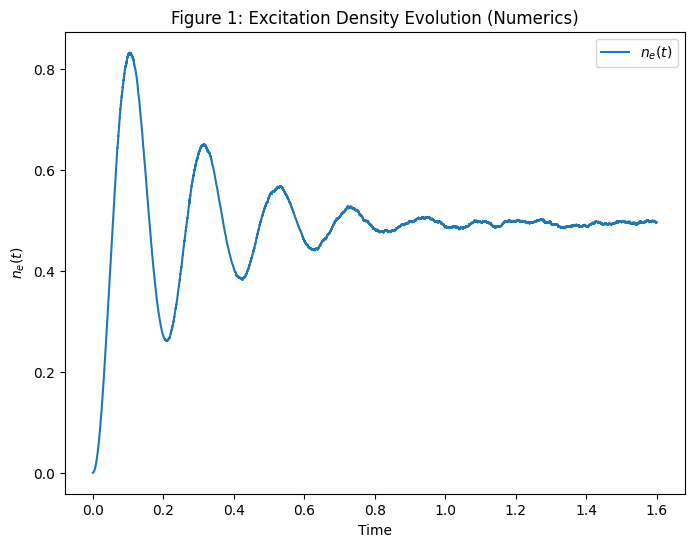

In [277]:
plt.figure(figsize=(8,6))
plt.plot(time_values, ne_avg1[0], label=r'$n_{e}(t)$')

plt.title('Figure 1: Excitation Density Evolution (Numerics)')
plt.xlabel('Time')
plt.ylabel(r'$n_{e}(t)$')
plt.legend()
plt.show()


Exact solution

In [278]:
# n_e of the stationary state

ne_infty = 1/ (2+gamma**2/(4*omega**2))
print("n_e(infinity)= ", ne_infty)

n_e(infinity)=  0.4931506849315069


In [279]:
# Initial state
u0 = np.array([1, 0, 0, 0], dtype=complex)

# Define the eigenvectors we've solved
u1 = np.array([1+gamma**2/(4*omega**2), 1j*gamma/(2*omega), -1j*gamma/(2*omega), 1], dtype=complex)
u2 = np.array([0, 1, 1, 0], dtype=complex)
u3 = np.array([-1, 1j*8*omega/(gamma+np.sqrt(gamma**2-64*omega**2,dtype=complex)), -1j*8*omega/(gamma+np.sqrt(gamma**2-64*omega**2,dtype=complex)), 1], dtype=complex)
u4 = np.array([-1, -1j*8*omega/(-gamma+np.sqrt(gamma**2-64*omega**2,dtype=complex)), 1j*8*omega/(-gamma+np.sqrt(gamma**2-64*omega**2,dtype=complex)), 1], dtype=complex)
u = [u1, u2, u3, u4]

# Define the eigenvalues we've solved
l1 = 0
l2 = -gamma/2
l3 = 1/4 * (-3*gamma - np.sqrt(gamma**2 - 64*omega**2, dtype=complex))
l4 = 1/4 * (-3*gamma + np.sqrt(gamma**2 - 64*omega**2, dtype=complex))
l = [l1, l2, l3, l4]

# Solve c1, c2, c3, c4 by Uc = d
U = np.zeros((4,4), dtype=complex)
d = np.zeros((4), dtype=complex)
for m in range(4):
    d[m] = dagger(u[m]) @ u0
    for n in range(4):
        U[m][n] = dagger(u[m]) @ u[n]

c = np.linalg.solve(U,d)

parameters = [c[0], c[1], c[2], c[3], l1, l2, l3, l4, u1, u2, u3, u4]

# Construct the solution rho(t) of the master equation
def Rho(parameters, t):
    state = np.array([0, 0, 0, 0], dtype=complex)
    for i in range(4):
        state += parameters[i] * np.exp(parameters[i+4]*t) * parameters[i+8] 
    return state



# Construct the excitation density ne(t)
n_e = []
n_e_infty_values = []
for t in time_values:
    norm = Rho(parameters, t)[0] + Rho(parameters, t)[3]
    n_e.append(Rho(parameters, t)[3]/norm)
    n_e_infty_values.append(ne_infty)


<a id="Figure2"></a>

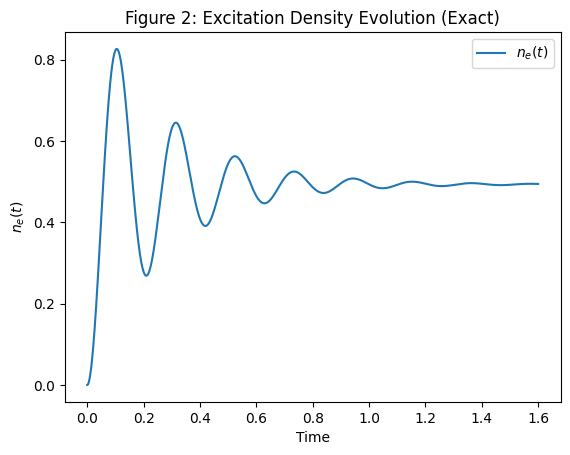

In [280]:
# Plot
n_e_exact_values = np.array(n_e)
plt.plot(time_values, n_e_exact_values, label=r'$n_e(t)$')
plt.title('Figure 2: Excitation Density Evolution (Exact)')
plt.xlabel('Time')
plt.ylabel(r'$n_{e}(t)$')
plt.legend()
plt.show()

<a id="Figure3"></a>

$n_{e}(t)$ numerics vs. exact

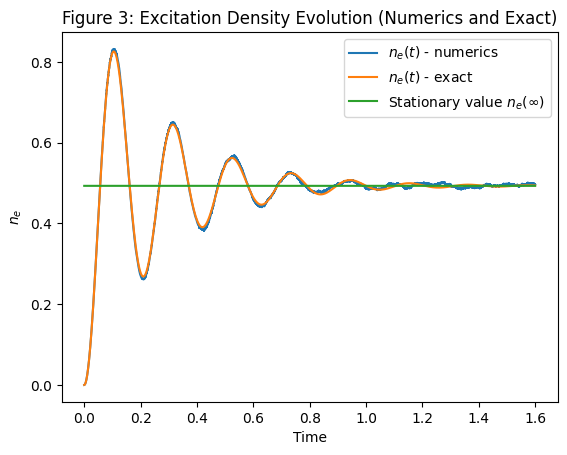

In [281]:
plt.plot(time_values, ne_avg1[0], label=r'$n_{e}(t)$ - numerics')
plt.plot(time_values, n_e_exact_values, label=r'$n_{e}(t)$ - exact')
plt.plot(time_values, n_e_infty_values, label=r'Stationary value $n_e(\infty)$')
plt.title('Figure 3: Excitation Density Evolution (Numerics and Exact)')
plt.xlabel('Time')
plt.ylabel(r'$n_{e}$')
plt.legend()
plt.show()

# 2. Interacting atoms

In [293]:
# Define the system
omega = 15
gamma = 2*omega/3
H = omega * (S_x(2,1) + S_x(2,2))
L = (S_minus(2,1) + S_minus(2,2)) / np.sqrt(2)
H_eff = effective_Hamiltonian(H,gamma, L)

# Define the simulation parameters
total_time = 1.6
dt = 0.000016
U_eff = expm(-1j * H_eff * dt)
t_length = int(total_time/dt)

For initial state $\ket{\psi(0)}= \ket{gg}=[1,0,0,0]$

In [283]:
N = 2700
N_ne1_values = []
N_ne2_values = []
N_state_vectors = []
for n in tqdm(range(N)):
    
    # start a new trajectory simulation        
    time_values = []
    state_vectors = []
    ne1_values = []
    ne2_values = []

    current_state = phi_basis_vecs(2)[0]
    current_time = 0
    while current_time < total_time:
        
        
        # propagation
        current_state_1 = U_eff @ current_state                      # get the candidate propagated state

        dp = jump_probability(current_state_1)
        r = np.random.rand()
        if r < dp:                                                   # jump occurs
            time_values.append(current_time)
            current_state = np.sqrt(gamma) * (L @ current_state)     # progapage by acting jump
            current_state = current_state / np.sqrt(dp/dt)           # normalize the state
            state_vectors.append(current_state)       
            ne1 = np.abs(current_state[2][0])**2 + np.abs(current_state[3][0])**2
            ne1_values.append(ne1) 
            ne2 = np.abs(current_state[1][0])**2 + np.abs(current_state[3][0])**2
            ne2_values.append(ne2)
            current_time += 0.01*dt                                  # update time with smaller dt
            
            
        else:
            time_values.append(current_time)
            current_state = current_state_1/ np.sqrt(1-dp)           # choose the candidate propagated state
            state_vectors.append(current_state)
            ne1 = np.abs(current_state[2][0])**2 + np.abs(current_state[3][0])**2
            ne1_values.append(ne1) 
            ne2 = np.abs(current_state[1][0])**2 + np.abs(current_state[3][0])**2
            ne2_values.append(ne2)
            current_time += dt                                       # update time with regular dt
            

        

    N_state_vectors.append(np.array(state_vectors))
    N_ne1_values.append(np.array(ne1_values))
    N_ne2_values.append(np.array(ne2_values))

print("Simulation complete")

100%|█████████████████████████████████████| 2700/2700 [1:47:42<00:00,  2.39s/it]

Simulation complete


In [284]:
time_values = time_values[:t_length]
for n in range(N):
    N_ne1_values[n]=N_ne1_values[n][:t_length]
    N_ne2_values[n]=N_ne2_values[n][:t_length]

<a id="Figure4-1"></a>

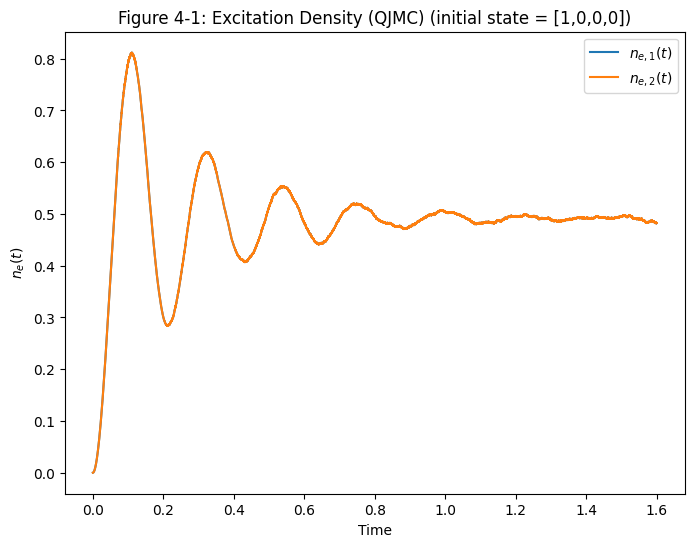

In [287]:
N_ne1_sum = np.array([0+0j]*len(N_ne1_values[0]), dtype=complex)
N_ne2_sum = np.array([0+0j]*len(N_ne2_values[0]), dtype=complex)
for n in range(N):
    N_ne1_sum += N_ne1_values[n]
    N_ne2_sum += N_ne2_values[n]

ne_avg2 = [[],[]]
avg1 = N_ne1_sum / N
avg2 = N_ne2_sum / N
ne_avg2[0].append(avg1)
ne_avg2[0].append(avg2)


plt.figure(figsize=(8,6))
plt.plot(time_values, ne_avg2[0][0], label=r'$n_{e,1}(t)$')
plt.plot(time_values, ne_avg2[0][1], label=r'$n_{e,2}(t)$')

plt.title('Figure 4-1: Excitation Density (QJMC) (initial state = [1,0,0,0])')
plt.xlabel('Time')
plt.ylabel(r'$n_e(t)$')
plt.legend()
plt.show()

Exact solution

In [286]:
# Build the matrix representation of the Lindbladian superoperator
gamma = omega/3

def Lind(rho):
    L1 = commutator(S_x(2,1)+S_x(2,2), rho, 0)
    L2 = L @ rho @ dagger(L) - 1/2 * commutator(dagger(L) @ L, rho, 1)
    return -1j * omega * L1 + 2 * gamma * L2

M2 = np.zeros((16,16),dtype=complex)
for m in range(16):
    for n in range(16):
        M2[m][n] = np.trace( dagger(rho_basis_ops(2)[m]) @ Lind(rho_basis_ops(2)[n]))
        
# Calculate eigenvalues and eigenvectors by sympy module
M2 = Matrix(M2)
eigenvalues = M2.eigenvals()
eigenvectors = M2.eigenvects()

# Store in numpy list
vectors = []
values = []
for i in range(16):
    value = np.squeeze(np.array(eigenvectors[i][0]).astype(complex))
    vector = np.squeeze(np.array(eigenvectors[i][2]).astype(complex))
    values.append(value)
    vectors.append(vector)
values = np.squeeze(values)

# Set up initial state rho(0)
phi = phi_basis_vecs(2)[0]
phiphi = np.outer(phi,phi)
u0 = phiphi.reshape(16)

# Solve c1, c2, ..., c16 by Uc = d
U = np.zeros((16,16), dtype=complex)
d = np.zeros((16), dtype=complex)
for m in range(16):
    d[m] = dagger(vectors[m]) @ u0
    for n in range(16):
        U[m][n] = dagger(vectors[m]) @ vectors[n]

c = np.linalg.solve(U,d)

# Construct the full solution rho(t) and rho_ss
parameters = []
parameters.append(c)
parameters.append(values)
parameters.append(vectors)

# rho_ss and n_e(infinity)
rho_stationary = parameters[0][13]*parameters[2][13] + parameters[0][14]*parameters[2][14]
norm = rho_stationary[0]+rho_stationary[5]+rho_stationary[10]+rho_stationary[15]
n_e_1_infty = (rho_stationary[10]+rho_stationary[15])/norm
n_e_2_infty = (rho_stationary[5]+rho_stationary[15])/norm

# rho(t)
def Rho(parameters, t):
    state = np.zeros((16), dtype=complex)
    for i in range(16):
        state += parameters[0][i] * np.exp(parameters[1][i]*t) * parameters[2][i] 
    return state



# Construct the excitation density n_e_1(t), n_e_2(t)
# n_e_1 = tr(|1)(1|_1 . rho) = tr(E3E3.rho) + tr(E4E4.rho) = rho[10] + rho[15]
# n_e_2 = tr(|1)(1|_2 . rho) = tr(E2E2.rho) + tr(E4E4.rho) = rho[5] + rho[15]
n_e_1 = []
n_e_2 = []
n_e_1_infty_values = []
n_e_2_infty_values = []

for t in time_values:
    n_e_1.append( (Rho(parameters, t)[10] + Rho(parameters, t)[15]) )
    n_e_2.append( (Rho(parameters, t)[5] + Rho(parameters, t)[15]) )
    n_e_1_infty_values.append(n_e_1_infty)
    n_e_2_infty_values.append(n_e_2_infty)

# n_e1 and n_e2 of stationary state
print(n_e_1_infty,n_e_2_infty)

(0.4905847373637265-2.7631037427530766e-18j) (0.4905847373637265-2.7631037427530766e-18j)


<a id="Figure4-2"></a>

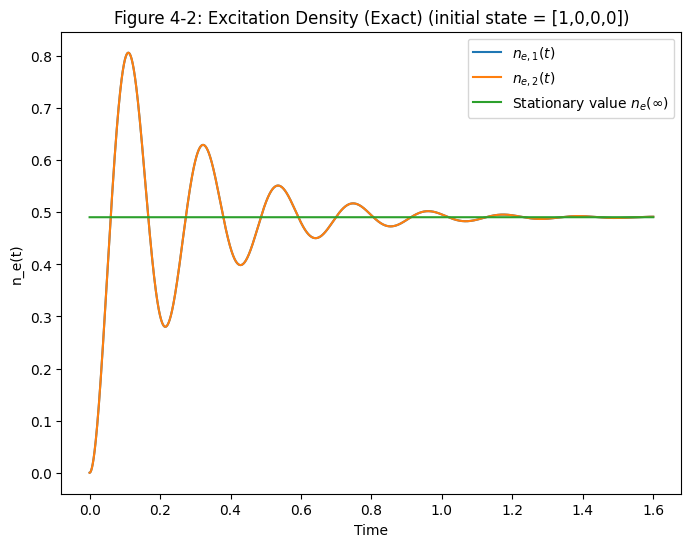

In [288]:
# Plot
plt.figure(figsize=(8,6))

plt.plot(time_values, n_e_1, label=r'$n_{e,1}(t)$')
plt.plot(time_values, n_e_2, label=r'$n_{e,2}(t)$')
plt.plot(time_values, n_e_1_infty_values, label=r'Stationary value $n_e(\infty)$')
plt.title('Figure 4-2: Excitation Density (Exact) (Initial state = [1,0,0,0])')


plt.xlabel('Time')
plt.ylabel('n_e(t)')
plt.legend()
plt.show()

Numerics vs. Exact

<a id="Figure4-3"></a>

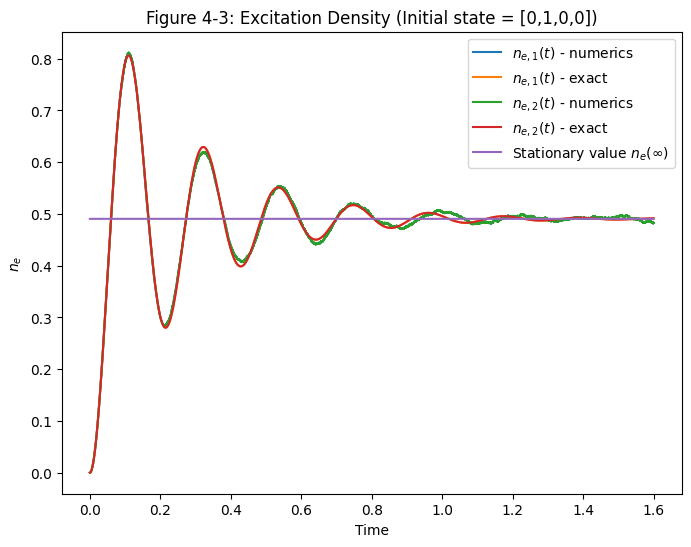

In [291]:
plt.figure(figsize=(8,6))
plt.plot(time_values, ne_avg2[0][0], label=r'$n_{e,1}(t)$ - numerics')
plt.plot(time_values, n_e_1, label=r'$n_{e,1}(t)$ - exact')
plt.plot(time_values, ne_avg2[0][1], label=r'$n_{e,2}(t)$ - numerics')
plt.plot(time_values, n_e_2, label=r'$n_{e,2}(t)$ - exact')
plt.plot(time_values, n_e_2_infty_values, label=r'Stationary value $n_e(\infty)$')
plt.title('Figure 4-3: Excitation Density (Initial state = [0,1,0,0])')

plt.xlabel('Time')
plt.ylabel(r'$n_e$')
plt.legend()
plt.show()

For initial state $\ket{\psi(0)}= \ket{ge} = [0,1,0,0]$

In [294]:
N = 2700
N_ne1_values = []
N_ne2_values = []
N_state_vectors = []
for n in tqdm(range(N)):
    
    # start a new trajectory simulation        
    time_values = []
    norm_values = []
    state_vectors = []
    ne1_values = []
    ne2_values = []

    # Initial conditions
    current_state = phi_basis_vecs(2)[1]
    current_time = 0
    while current_time < total_time:
        
        
        # propagation
        current_state_1 = U_eff @ current_state                      # get the candidate propagated state

        dp = jump_probability(current_state_1)
        r = np.random.rand()
        if r < dp:                                                   # jump occurs
            time_values.append(current_time)
            current_state = np.sqrt(gamma) * (L @ current_state)     # progapage by acting jump
            current_state = current_state / np.sqrt(dp/dt)           # normalize the state
            state_vectors.append(current_state)       
            ne1 = np.abs(current_state[2][0])**2 + np.abs(current_state[3][0])**2
            ne1_values.append(ne1) 
            ne2 = np.abs(current_state[1][0])**2 + np.abs(current_state[3][0])**2
            ne2_values.append(ne2)
            current_time += 0.01*dt                                  # update time with smaller dt
            
        else:
            time_values.append(current_time)
            current_state = current_state_1/ np.sqrt(1-dp)           # choose the candidate propagated state
            state_vectors.append(current_state)
            ne1 = np.abs(current_state[2][0])**2 + np.abs(current_state[3][0])**2
            ne1_values.append(ne1) 
            ne2 = np.abs(current_state[1][0])**2 + np.abs(current_state[3][0])**2
            ne2_values.append(ne2)
            current_time += dt                                       # update time with regular dt

        

    N_state_vectors.append(np.array(state_vectors))
    N_ne1_values.append(np.array(ne1_values))
    N_ne2_values.append(np.array(ne2_values))

print("Simulation complete")

100%|█████████████████████████████████████| 2700/2700 [2:00:21<00:00,  2.67s/it]

Simulation complete


<a id="Figure4"></a>

In [296]:
time_values = time_values[:t_length]
for n in range(N):
    N_ne1_values[n]=N_ne1_values[n][:t_length]
    N_ne2_values[n]=N_ne2_values[n][:t_length]

N_ne1_sum = np.array([0+0j]*len(N_ne1_values[0]), dtype=complex)
N_ne2_sum = np.array([0+0j]*len(N_ne2_values[0]), dtype=complex)
for n in range(N):
    N_ne1_sum += N_ne1_values[n]
    N_ne2_sum += N_ne2_values[n]

avg1 = N_ne1_sum / N
avg2 = N_ne2_sum / N
ne_avg2[1].append(avg1)
ne_avg2[1].append(avg2)

<a id="Figure4-4"></a>

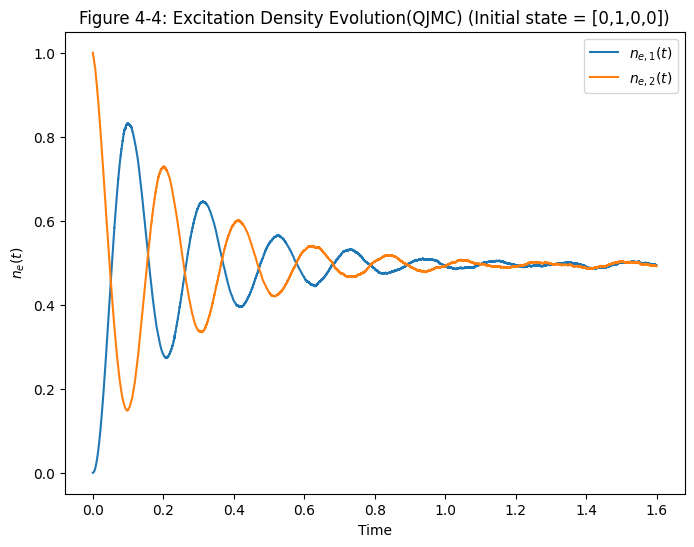

In [299]:
plt.figure(figsize=(8,6))
plt.plot(time_values, ne_avg2[1][0], label=r'$n_{e,1}(t)$')
plt.plot(time_values, ne_avg2[1][1], label=r'$n_{e,2}(t)$')

plt.title('Figure 4-4: Excitation Density Evolution(QJMC) (Initial state = [0,1,0,0])')
plt.xlabel('Time')
plt.ylabel(r'$n_e(t)$')
plt.legend()
plt.show()

Exact solution

In [298]:
# Build the matrix representation of the Lindbladian superoperator
gamma = omega/3

def Lind(rho):
    L1 = commutator(S_x(2,1)+S_x(2,2), rho, 0)
    L2 = L @ rho @ dagger(L) - 1/2 * commutator(dagger(L) @ L, rho, 1)
    return -1j * omega * L1 + 2 * gamma * L2

M2 = np.zeros((16,16),dtype=complex)
for m in range(16):
    for n in range(16):
        M2[m][n] = np.trace( dagger(rho_basis_ops(2)[m]) @ Lind(rho_basis_ops(2)[n]))

# Calculate eigenvalues and eigenvectors by sympy module
M2 = Matrix(M2)
eigenvalues = M2.eigenvals()
eigenvectors = M2.eigenvects()

# Store in numpy list
vectors = []
values = []
for i in range(16):
    value = np.squeeze(np.array(eigenvectors[i][0]).astype(complex))
    vector = np.squeeze(np.array(eigenvectors[i][2]).astype(complex))
    values.append(value)
    vectors.append(vector)
values = np.squeeze(values)

# Set up initial state rho(0)
phi = phi_basis_vecs(2)[1]
phiphi = np.outer(phi,phi)
u0 = phiphi.reshape(16)

# Solve c1, c2, ..., c16 by Uc = d
U = np.zeros((16,16), dtype=complex)
d = np.zeros((16), dtype=complex)
for m in range(16):
    d[m] = dagger(vectors[m]) @ u0
    for n in range(16):
        U[m][n] = dagger(vectors[m]) @ vectors[n]

c = np.linalg.solve(U,d)

# Construct the full solution rho(t) and rho_ss
parameters = []
parameters.append(c)
parameters.append(values)
parameters.append(vectors)

# rho_ss and n_e(infinity)
rho_stationary = parameters[0][13]*parameters[2][13] + parameters[0][14]*parameters[2][14]
norm = rho_stationary[0]+rho_stationary[5]+rho_stationary[10]+rho_stationary[15]
n_e_1_infty = (rho_stationary[10]+rho_stationary[15])/norm
n_e_2_infty = (rho_stationary[5]+rho_stationary[15])/norm

# rho(t)
def Rho(parameters, t):
    state = np.zeros((16), dtype=complex)
    for i in range(16):
        state += parameters[0][i] * np.exp(parameters[1][i]*t) * parameters[2][i] 
    return state



# Construct the excitation density n_e_1(t), n_e_2(t)
# n_e_1 = tr(|1)(1|_1 . rho) = tr(E3E3.rho) + tr(E4E4.rho) = rho[10] + rho[15]
# n_e_2 = tr(|1)(1|_2 . rho) = tr(E2E2.rho) + tr(E4E4.rho) = rho[5] + rho[15]
n_e_1 = []
n_e_2 = []
n_e_1_infty_values = []
n_e_2_infty_values = []

for t in time_values:
    n_e_1.append( (Rho(parameters, t)[10] + Rho(parameters, t)[15]) )
    n_e_2.append( (Rho(parameters, t)[5] + Rho(parameters, t)[15]) )
    n_e_1_infty_values.append(n_e_1_infty)
    n_e_2_infty_values.append(n_e_2_infty)

# n_e1 and n_e2 of stationary state
print(n_e_1_infty,n_e_2_infty)

(0.49529236868186327-6.780293070746787e-20j) (0.49529236868186327-6.780293070746787e-20j)


<a id="Figure4-5"></a>

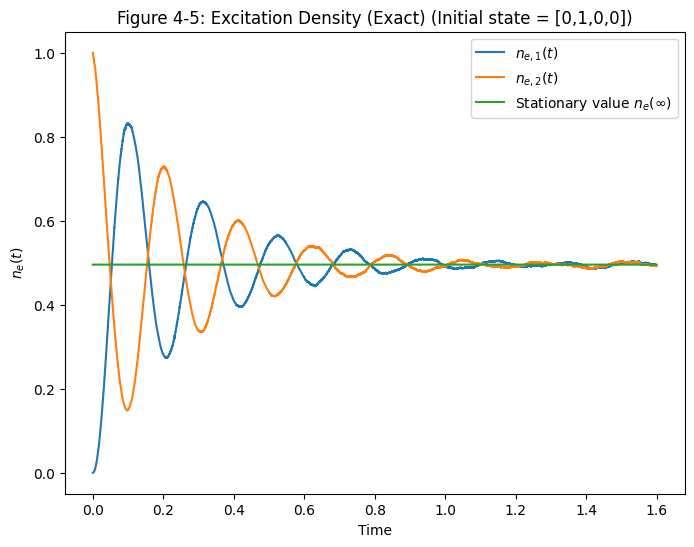

In [300]:
# Plot
plt.figure(figsize=(8,6))

plt.plot(time_values, ne_avg2[1][0], label=r'$n_{e,1}(t)$')
plt.plot(time_values, ne_avg2[1][1], label=r'$n_{e,2}(t)$')
plt.plot(time_values, n_e_1_infty_values, label=r'Stationary value $n_e(\infty)$')

plt.title('Figure 4-5: Excitation Density (Exact) (Initial state = [0,1,0,0])')


plt.xlabel('Time')
plt.ylabel(r'$n_e(t)$')
plt.legend()
plt.show()

# $n_{e,1}(t)$, $n_{e,2}(t)$ numerics vs. exact

<a id="Figure4-6"></a>

<a id="Figure4-7"></a>

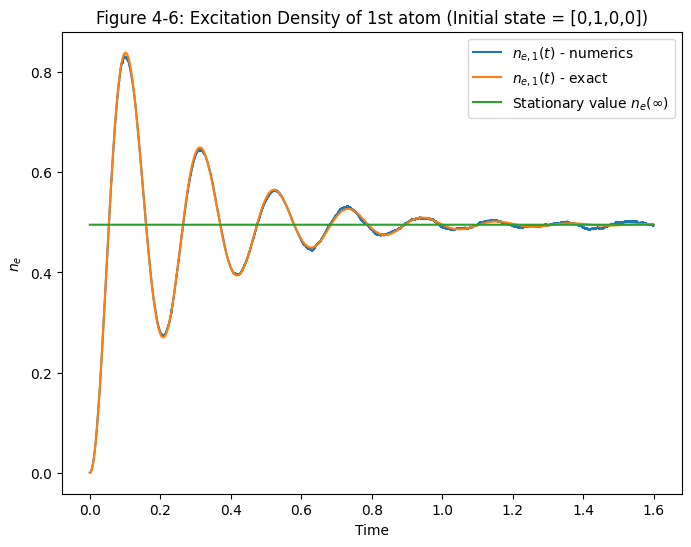

In [301]:
plt.figure(figsize=(8,6))
plt.plot(time_values, ne_avg2[1][0], label=r'$n_{e,1}(t)$ - numerics')
plt.plot(time_values, n_e_1, label=r'$n_{e,1}(t)$ - exact')
plt.plot(time_values, n_e_1_infty_values, label=r'Stationary value $n_e(\infty)$')
plt.title('Figure 4-6: Excitation Density of 1st atom (Initial state = [0,1,0,0])')

plt.xlabel('Time')
plt.ylabel(r'$n_e$')
plt.legend()
plt.show()

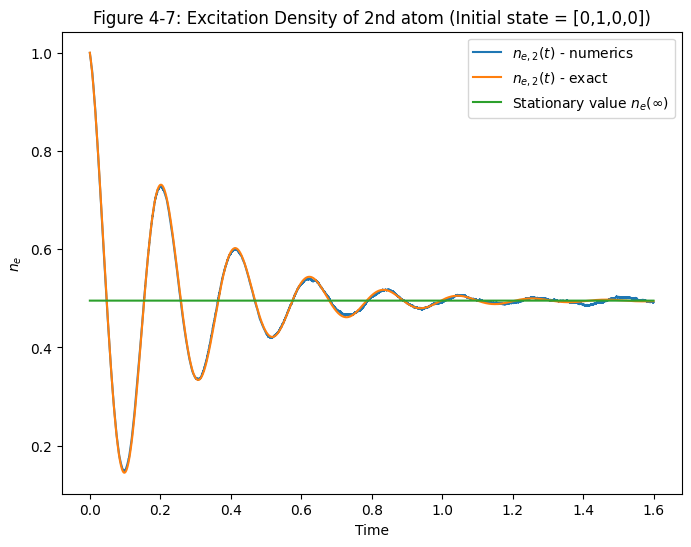

In [302]:
plt.figure(figsize=(8,6))
plt.plot(time_values, ne_avg2[1][1], label=r'$n_{e,2}(t)$ - numerics')
plt.plot(time_values, n_e_2, label=r'$n_{e,2}(t)$ - exact')
plt.plot(time_values, n_e_2_infty_values, label=r'Stationary value $n_e(\infty)$')
plt.title('Figure 4-7: Excitation Density of 2nd atom (Initial state = [0,1,0,0])')

plt.xlabel('Time')
plt.ylabel(r'$n_e$')
plt.legend()
plt.show()

<a id="Figure4-7"></a>